In [1]:
from processing_utils import DataPrepare
from studu_utils import load_best_global, save_best_global, plot_feature_importance, permutation_feature_importance, plot_feature_premutation_importance, plot_predictions


import polars as pl
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt
import optuna
from scipy.signal import savgol_filter



In [2]:
df: pl.DataFrame = pl.read_parquet(r'C:\Users\310\Desktop\Progects_Py\data\microstructure_price_prediction_data\dfs\2024-06-29 20-00-00_2024-07-01 00-00-00_delta_0-00-10_return_5_sec.parquet')
target_var: str = "log_return"
cols_to_exclude: list[str] = []
# File to store the best global results
BEST_GLOBAL_FILE = "best_global_RF.json"

In [3]:
data = DataPrepare(df)

In [4]:
data.normalize(cross_section_id="cross_section_id", exclude_columns=["currency_pair", target_var])

currency_pair,cross_section_id,log_interval_return,num_aggregated_trades,volume_imbalance_FIVE_SECONDS,volume_imbalance_TEN_SECONDS,volume_imbalance_HALF_MINUTE,volume_imbalance_MINUTE,slippage_imbalance_FIVE_SECONDS,slippage_imbalance_TEN_SECONDS,slippage_imbalance_HALF_MINUTE,slippage_imbalance_MINUTE,log_return
str,datetime[μs],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""DOGEUSDT""",2024-06-29 20:00:10,-0.707107,0.707107,0.707107,-0.707107,-0.707107,-0.707107,NaN,0.707107,0.707107,0.707107,0.000081
"""AVAXUSDT""",2024-06-29 20:00:10,0.707107,-0.707107,-0.707107,0.707107,0.707107,0.707107,NaN,-0.707107,-0.707107,-0.707107,0.000358
"""DOGEUSDT""",2024-06-29 20:00:20,-0.707107,0.707107,NaN,0.707107,0.707107,0.707107,NaN,NaN,NaN,NaN,-0.000081
"""AVAXUSDT""",2024-06-29 20:00:20,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,NaN,NaN,NaN,0.000358
"""DOGEUSDT""",2024-06-29 20:00:30,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,-0.000081
…,…,…,…,…,…,…,…,…,…,…,…,…
"""AVAXUSDT""",2024-06-30 23:59:40,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,0.0,0.0,0.0,0.00034
"""DOGEUSDT""",2024-06-30 23:59:50,0.707107,-0.707107,NaN,-0.707107,-0.707107,-0.707107,NaN,NaN,NaN,NaN,0.0
"""AVAXUSDT""",2024-06-30 23:59:50,-0.707107,0.707107,NaN,0.707107,0.707107,0.707107,NaN,NaN,NaN,NaN,null


In [5]:
data.train_test_split(train_test_ratio=0.7, exclude_columns="cross_section_id")
X_train, y_train, X_test, y_test, = data.X_y_split(target_var=target_var, target_encode=True)

Train test ratio is 0.7
Train len for DOGEUSDT is 6664
Test len for DOGEUSDT is 2856
Train len for AVAXUSDT is 5763
Test len for AVAXUSDT is 2470


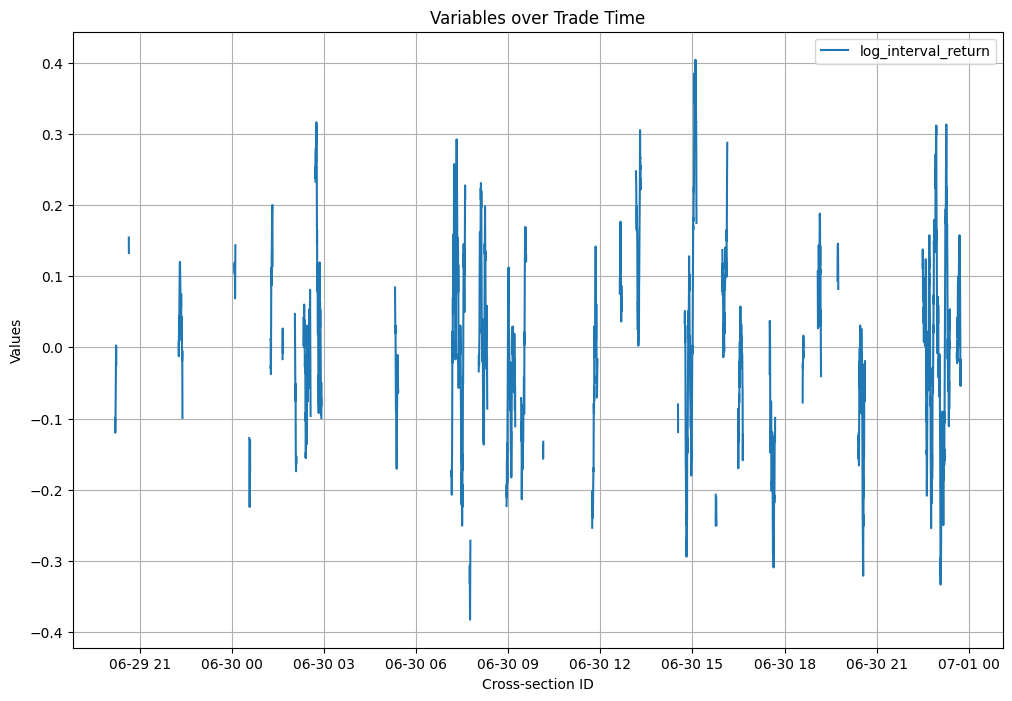

In [11]:
data.visualize(datetime(2024, 6, 20), datetime(2024, 7, 1), variables_to_plot=["log_interval_return"])

In [24]:
# Initialize best global results
best_global = load_best_global(BEST_GLOBAL_FILE)

In [25]:
def objective(trial, X_train, y_train, features):
    # Store the features in trial user attributes
    trial.set_user_attr("features", features)

    # Hyperparameter space
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_weight_fraction_leaf = trial.suggest_float("min_weight_fraction_leaf", 0.0, 0.5)
    min_impurity_decrease = trial.suggest_float("min_impurity_decrease", 0.0, 0.5)

    # Define the RandomForestRegressor with trial parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_weight_fraction_leaf=min_weight_fraction_leaf,
        min_impurity_decrease=min_impurity_decrease,
        random_state=42,
        n_jobs=-1,
    )

    # Use K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mse_scores = -cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv=kf)

    return np.mean(mse_scores)


In [26]:
def optimize_with_dataset(X_train, y_train, study_name=None):
    global best_global

    features = list(X_train.columns)

    if study_name:
        pass
    if features == best_global["features"]:
        study_name = best_global["study_name"]
    else:
        study_name = datetime.now().strftime("study_%Y-%m-%d_%H-%M-%S")
    

    # Create a new study
    study = optuna.create_study(
        study_name=study_name,
        storage="sqlite:///optuna_study_RF.db",
        direction="minimize",
        load_if_exists=True
    )

    # Run optimization
    study.optimize(lambda trial: objective(trial, X_train, y_train, features), n_trials=1)

    # Update the global best result if the current study has a better score
    if study.best_value < best_global["best_value"]:
        best_global.update(
            {
                "study_name": study_name,
                "best_value": study.best_value,
                "best_params": study.best_params,
                "features": features,
            }
        )
        # Save the updated best global results to disk
        save_best_global(best_global, BEST_GLOBAL_FILE)

    print(f"Study: {study_name}")
    print(f"Best Value: {study.best_value}")
    print(f"Best Params: {study.best_params}")

    return study


In [29]:
study = optimize_with_dataset(X_train, y_train)

[I 2024-12-19 20:33:22,027] A new study created in RDB with name: study_2024-12-19_20-33-21
[I 2024-12-19 20:33:22,808] Trial 0 finished with value: 2.7135727595816466e-08 and parameters: {'n_estimators': 51, 'max_depth': 36, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.3154727107896868, 'min_impurity_decrease': 0.4626564506099459}. Best is trial 0 with value: 2.7135727595816466e-08.


Study: study_2024-12-19_20-33-21
Best Value: 2.7135727595816466e-08
Best Params: {'n_estimators': 51, 'max_depth': 36, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.3154727107896868, 'min_impurity_decrease': 0.4626564506099459}


In [28]:
# To open dashbourd run this:
!optuna-dashboard sqlite:///optuna_study_RF.db

# And listen to:
# http://localhost:8080/


^C


MSE on test: 0.0000 
MAPE on test: 12216691427.4783


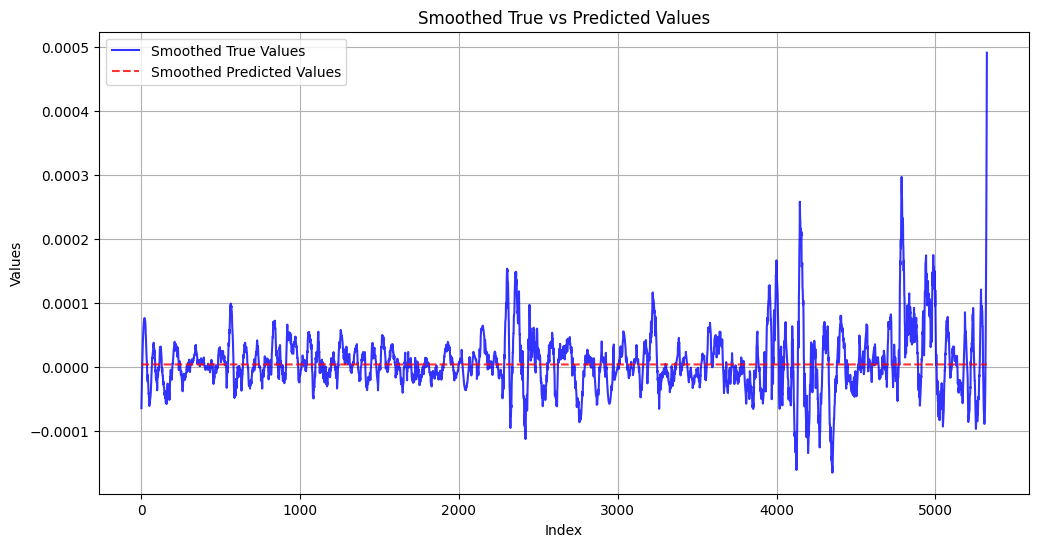

In [44]:
# Test
rf_model = RandomForestRegressor(**study.best_params, random_state=42)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"MSE on test: {mse:.4f} \nMAPE on test: {mape:.4f}")
plot_predictions(y_test, y_pred)


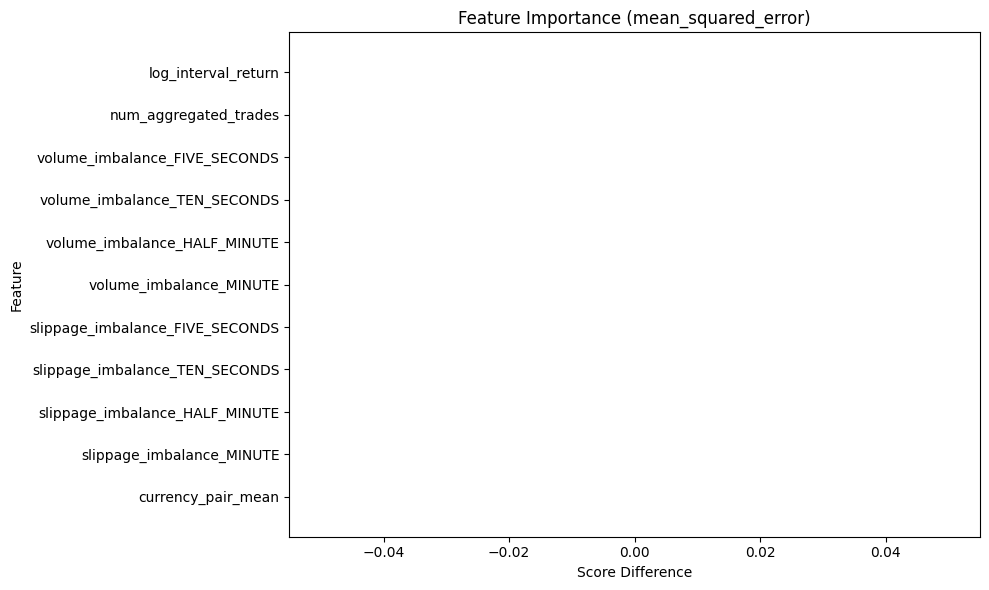

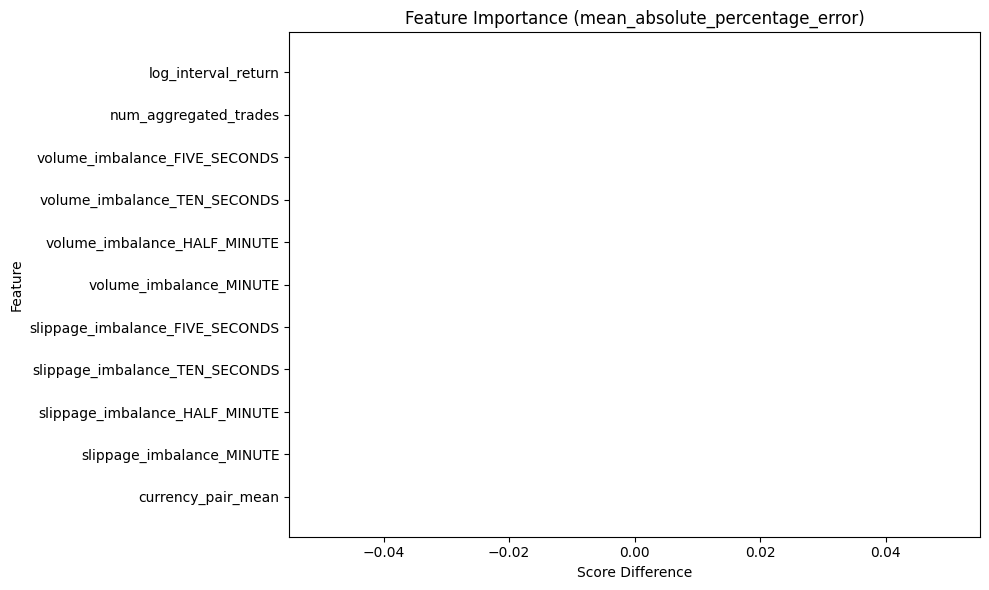

In [39]:
results = permutation_feature_importance(model=rf_model, X_test=X_test, y_test=y_test, metrics=[mean_squared_error, mean_absolute_percentage_error])
plot_feature_premutation_importance(results)

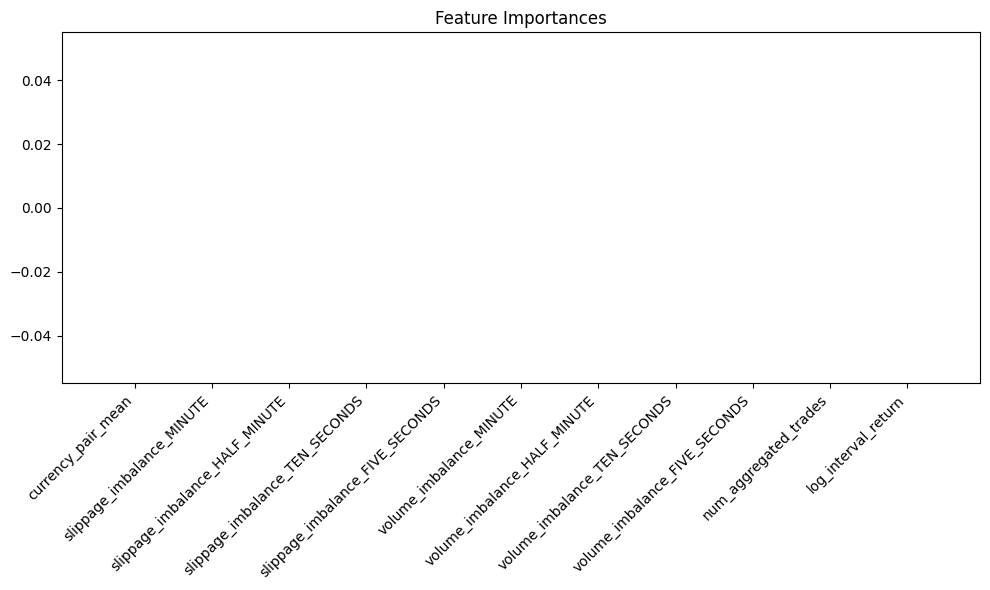

In [40]:
plot_feature_importance(rf_model, X_train.columns)